In [2]:
%load_ext autoreload
%autoreload 2
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone.utils.torch import FiftyOneTorchDataset

In [3]:
import utils

/home/jacobs/miniconda3/envs/torch-dataset/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import torchvision.transforms.v2 as transforms
from torchvision import tv_tensors
import matplotlib.pyplot as plt
import matplotlib.patches as plt_patches
from PIL import Image


In [5]:
torch.multiprocessing.set_start_method('forkserver')

# The `cache_field` Argument

Typically, the `FiftyOneTorchDataset` opens up a connection to the backing database for the given samples passed and queries it for the needed samples during runtime. This is pretty slow, and we don't want this overhead in our training loop.

To get around this, we offer the argument `cache_fields`. This argument accepts a list of string field names. When passed to `to_torch`, the `FiftyOneTorchDataset` object that is constructed will load up the the passed fields to memory so that we can quickly access them during training. This makes a very significant difference for the speed of sample retrievel. If you find that you are bottlenecked by the speed of your dataloader when using `FiftyOneTorchDataset`, consider using this argument.

Here is a tutorial on how it works.

# Load Dataset

In [6]:
dataset = foz.load_zoo_dataset("quickstart")

Dataset already downloaded
Loading existing dataset 'quickstart'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [ ]:
# make sure it's persistent
print(dataset.persistent)

# if it's not, set this variable to True
if not dataset.persistent:
    dataset.persistent = True

True


In [8]:
some_interesting_view = dataset.take(100)

# Passing Field Names to `cache_fields`

Here is an example of what happens when we pass some values to `cache_fields`. We will again use an identity `get_item` in order to see what the dataset is returning for us on query.

In [9]:
def get_item_identity(x):
    return x

In [10]:
fields_of_interest = ['id', 'filepath']

In [11]:
# Notice that that as soon as we construct the dataset, our fields are serialized and put on memory
torch_dataset = some_interesting_view.to_torch(get_item_identity, cache_fields=fields_of_interest)

Serializing 100 elements to byte tensors and concatenating them all ...
Serialized dataset takes 0.00 MiB
Serializing 100 elements to byte tensors and concatenating them all ...
Serialized dataset takes 0.01 MiB


In [12]:
# when we access the dataset, we get a dictionary with the values we wanted
print(torch_dataset[0])

{'id': '6764b003b388959771dfdf5c', 'filepath': '/home/jacobs/fiftyone/quickstart/data/003659.jpg'}


# A New `get_item`

Recall that in the previous example, our `get_item` function took a FiftyOne Sample as input, and returned model inputs. This will not work in this case, because as we saw, when the `cache_field` argument is passed, the `FiftyOneTorchDataset` will give us a dict with keys and values corresponding to the fields we passed.

Let's rewrite our `get_item` function from the last example to account for this.

In [13]:
augmentations = transforms.Compose([
    transforms.CenterCrop(512),
    transforms.ClampBoundingBoxes()
])
def get_item_cached(sample_dict):
        res = {}
        image = Image.open(sample_dict['filepath'])
        og_wh = np.array([image.width, image.height])
        image = tv_tensors.Image(image)
        detections = sample_dict['ground_truth.detections.bounding_box']
        detections_tensor = torch.tensor(detections) if len(detections) > 0 \
            else torch.zeros((0,4))
        res['box'] = tv_tensors.BoundingBoxes(detections_tensor * torch.tensor([*og_wh, *og_wh]),
            format=tv_tensors.BoundingBoxFormat('XYWH'),
            canvas_size=image.shape[-2:]
        ) 
        res['label'] = sample_dict['ground_truth.detections.label']
        res['id'] = sample_dict['id']
        image, res = augmentations(image, res)
        return image, res

In [14]:
# we have to make sure we pass all of the fields used by our get_item
fields_of_interest = [
    'id',
    'filepath',
    'ground_truth.detections.bounding_box',
    'ground_truth.detections.label'
]
torch_dataset = some_interesting_view.to_torch(get_item_cached, cache_fields=fields_of_interest)

Serializing 100 elements to byte tensors and concatenating them all ...
Serialized dataset takes 0.00 MiB
Serializing 100 elements to byte tensors and concatenating them all ...
Serialized dataset takes 0.01 MiB
Serializing 100 elements to byte tensors and concatenating them all ...
Serialized dataset takes 0.02 MiB
Serializing 100 elements to byte tensors and concatenating them all ...
Serialized dataset takes 0.01 MiB


# Visualizing the result

Same as before, we can visualize the result

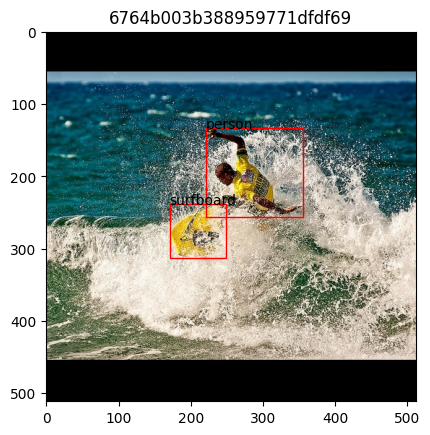

In [15]:
# run this a couple of times to look through samples in the dataset
random_index = np.random.randint(0, len(torch_dataset))
image, res = torch_dataset[random_index]
plt.title(res['id'])
plt.imshow(image.permute(1, 2, 0).numpy())
axes = plt.gca()
for b, l in zip(res['box'], res['label']):
    rect = plt_patches.Rectangle((b[0], b[1]),
                                    b[2], b[3],
                                    linewidth=1, edgecolor='r', facecolor='none')
    axes.add_patch(rect)
    axes.annotate(l, rect.get_xy())
plt.show()

And again, we can create dataloaders and work with the dataset during training.

In [29]:
# utils.get_item_cached_quickstart is the same get_item_cached as above.
fields_of_interest = [
    'id',
    'filepath',
    'ground_truth.detections.bounding_box',
    'ground_truth.detections.label'
]
torch_dataset = some_interesting_view.to_torch(utils.get_item_cached_quickstart, cache_fields=fields_of_interest)
dataloader = utils.create_dataloader_simple(torch_dataset)

Serializing 100 elements to byte tensors and concatenating them all ...
Serialized dataset takes 0.00 MiB
Serializing 100 elements to byte tensors and concatenating them all ...
Serialized dataset takes 0.01 MiB
Serializing 100 elements to byte tensors and concatenating them all ...
Serialized dataset takes 0.02 MiB
Serializing 100 elements to byte tensors and concatenating them all ...
Serialized dataset takes 0.01 MiB


In [30]:
ids_seen = utils.ids_in_dataloader(dataloader)

In [31]:
# confirm we have seen each sample once
from collections import Counter
ids_with_counts = Counter(ids_seen)
assert set(ids_with_counts.keys()) == set(some_interesting_view.values('id'))
assert np.all(np.array(list(ids_with_counts.values())) == 1)

In [33]:
# visualizing results, run this a couple of times to see different batches
iterator = iter(dataloader)

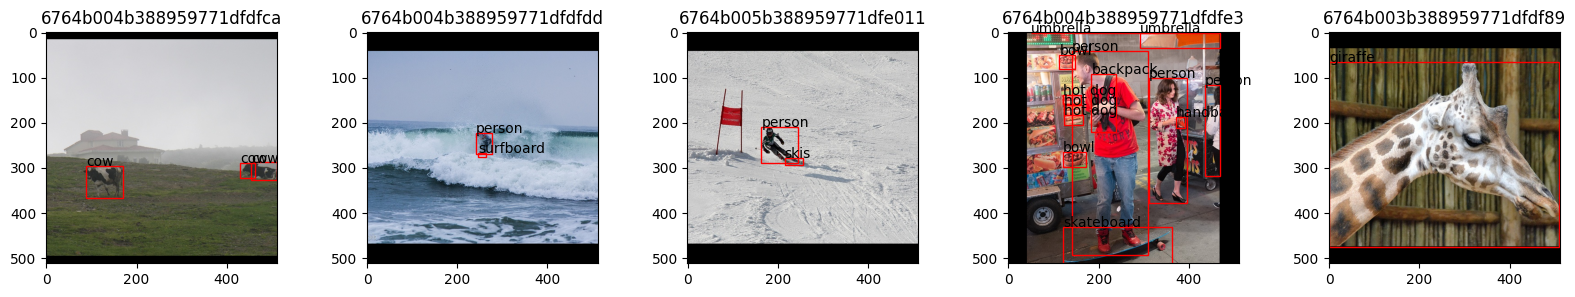

In [34]:
image, res = next(iterator)

fig, axes = plt.subplots(1, len(image), figsize=(4 * len(image), 3))

for i, img in enumerate(image):
    axes[i].set_title(res[i]['id'])
    axes[i].imshow(img.permute(1, 2, 0).numpy())
    for b, l in zip(res[i]['box'], res[i]['label']):
        rect = plt_patches.Rectangle((b[0], b[1]),
                                        b[2], b[3],
                                        linewidth=1, edgecolor='r', facecolor='none')
        axes[i].add_patch(rect)
        axes[i].annotate(l, rect.get_xy())

plt.show()